**Engy-5310** Computational Continuum Transport Phenomena, UMass Lowell, Chem. Eng. Nuclear Program Spring 2021; Prof. V. F. de Almeida

# Tritium Calculation for Molten Salt Reactor
$  
  \newcommand{\Amtrx}{\boldsymbol{\mathsf{A}}}
  \newcommand{\Bmtrx}{\boldsymbol{\mathsf{B}}}
  \newcommand{\Mmtrx}{\boldsymbol{\mathsf{M}}}
  \newcommand{\Imtrx}{\boldsymbol{\mathsf{I}}}
  \newcommand{\Pmtrx}{\boldsymbol{\mathsf{P}}}
  \newcommand{\Lmtrx}{\boldsymbol{\mathsf{L}}}
  \newcommand{\Umtrx}{\boldsymbol{\mathsf{U}}}
  \newcommand{\Smtrx}{\boldsymbol{\mathsf{S}}}
  \newcommand{\xvec}{\boldsymbol{\mathsf{x}}}
  \newcommand{\uvar}{\boldsymbol{u}}
  \newcommand{\fvar}{\boldsymbol{f}}
  \newcommand{\avec}{\boldsymbol{\mathsf{a}}}
  \newcommand{\bvec}{\boldsymbol{\mathsf{b}}}
  \newcommand{\cvec}{\boldsymbol{\mathsf{c}}}
  \newcommand{\rvec}{\boldsymbol{\mathsf{r}}}
  \newcommand{\mvec}{\boldsymbol{\mathsf{m}}}
  \newcommand{\gvec}{\boldsymbol{\mathsf{g}}}
  \newcommand{\zerovec}{\boldsymbol{\mathsf{0}}}
  \newcommand{\norm}[1]{\bigl\lVert{#1}\bigr\rVert}
  \newcommand{\transpose}[1]{{#1}^\top}
  \DeclareMathOperator{\rank}{rank}
  \newcommand{\Power}{\mathcal{P}}
$

**Student(s):** Anthony Bowers  <br>
**Course:** Engy-5310 Computational Continuum Transport Phenomena  <br>
**Mentor:** Prof. Subash Sharma

UMass Lowell, Dept. of Chemical Engineering, Nuclear Energy Program 
<br>
**25Apr2021**

---
## Table of Contents<a id="toc"></a>
* [Introduction](#intro)
* [Problem Statement](#problem)
* [Objectives](#obj)
* [Approach](#app)
 + [Weak Form of Problem Statement](#weakform)
 + [MOOSE Kernels](#kernels)
 + [Mesh](#kernels)
 + [Evaluation of Error](#Error)
 + [Setup](#setup)
 
* [Results and Analysis](#ranalysis)
* [Conclusions](#conclusions)
* [References](#refs)
---

## [Introduction](#toc)<a id="intro"></a>

Recent technology advances are creating growing interest in nuclear reactors that require advance high temperature salt coolants like Molten Salt Reactor (MSR). In a MSR the fuel is dissolved in the coolant salt with operating temperature at a range of $700^{o}C$ and $1000^{o}C$. At this temperature range the liquid salt produces tritium that can diffuse through metallic heat exchangers and escape the reactor system. To avoid exceeding allowable tritium releases to the environment, tritium removal from the salt coolant and barriers is required. 

In a lithium-containing MSR, the primary tritium-producing reactions as follow

$${^{7}_{3}}LiF + n → {^{4}_{2}}He + TF $$
$${^{7}_{3}}LiF + n → {^{4}_{2}}He + TF + n' $$
$${^{19}_{9}}F + n → {^{17}_{8}}O + T $$
$${^{9}_{4}}BeF_2 + n → {^{4}_{2}}He + {^{4}_{2}}He + 2F $$


The production rate for the ternary fission reactions, seen above, in an FHR is given by Cisneros (2013). In addition to the production of tritium by ternary fission reactions, tritium is also produced by corrosion, where in an FHR the corrosion reaction (Oxidation of Cr) is given by. 

$$TF + Cr_{S.S} → CrF_2 + T_{2(g)} $$

Therefore, the purpose of this project is to understand the tritium transport phenomena and select the correct model which will be tested in MOOSE. MOOSE is a partial differential solver using Finite Element Method (FEM) developed by Idaho National Laboratory. There are already existing models available in literature that have been benchmarks such as TRITium Diffusion EvolutionN and Transport (TRIDENT) developed by Stempien et al (2015,2016) at MIT. 


## [Problem Statement](#toc)<a id="problem"></a>

Consider tritium flowing co-currently, at steady-state, in the main coolant leg with fuel-salt at an initial concentration, u ,and velocity, v. Tritium at the centerline of the bulk fluid is at its max concentration. Alternatively, no tritium is to be diffused into centerline. The latter case was considered in this model. Furthermore, sources indicate that tritium will diffuse into the pipe wall and the diffusion is limited by the mass transfer relation. The mass transfer coefficient was estimated using a Sherwood expression as such: 

$$Sh_{T_2,Pipe}=0.015Re^{0.83}Sc^{0.42}$$

The concentration of tritium in the pipe wall for an infinite slab was assumed to be 0. Lastly, no tritium was to diffuse at the exit flow. 

In [46]:
'''Domain'''

def show_domain():
    import pyvista as pv
    pv.set_plot_theme('paraview')

    height = 150
    radius = 7.5 
    coolant = pv.Cylinder(center=(0,0,0), direction=(1,0,0), height=height, radius=radius)

    plo = pv.Plotter(notebook=True,shape=(1,1)) 
    plo.add_mesh(coolant, color='red', opacity=1.0,)
   
    plo.add_axes(xlabel='Z', ylabel='R', zlabel='')
    plo.set_viewup([0,1,0])
   
    cpos = plo.show(window_size=[800, 600])

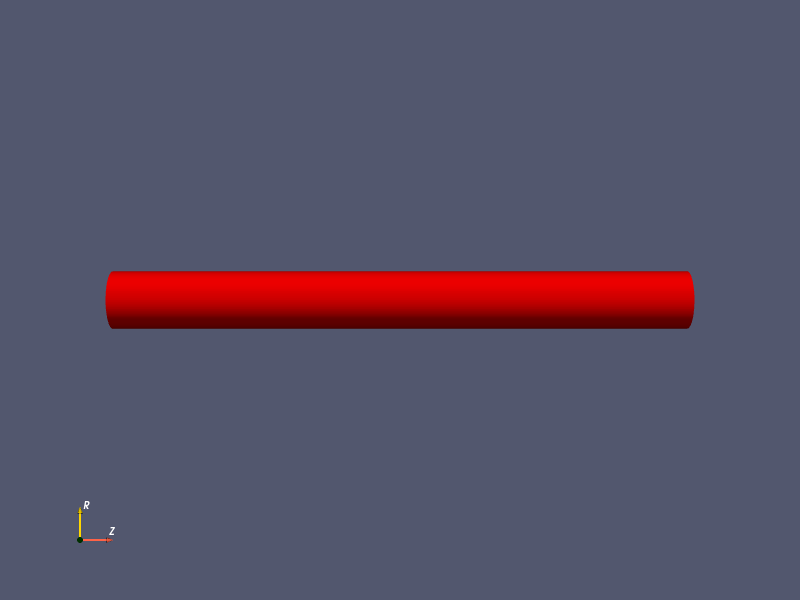

In [47]:
show_domain()

## [Objectives](#toc)<a id="obj"></a>

1.	Obtain transport parameters of tritium in main coolant leg
<br> a.	Peclet number 
<br> b.	Reynolds number
<br> c.	Diffusion coefficients
<br> d.	Fluid properties
2.	Develop Weak form of transport equation
3.	Use MOOSE to determine theoretical solution
4.	Compare analytical to MOOSE


## [Approach](#toc)<a id="app"></a>

    

### [Strong Form of Problem Statement](#toc)<a id="strongform"></a> 

<br>

Consider the transport of tritium following a 2-D Poisson’s model 
\begin{align*}
-D\nabla^2 u +\vec{v}\nabla u = 0 \\
\end{align*}

Given that the convective term will be much greater than the diffusion in the z-axis it can be neglected. Additionaly, convection in the r-axis does not exist in Steady-State conditions. 
\begin{align*}
-\frac{1} {r} \frac{d} {dr}\ ( \ Dr \frac{du} {dr} \ ) \ + \vec{v} \frac{du}{dz} \ = 0. 
\end{align*}

such that for all $ u: [(z_a, z_b); (r_a, r_b)] ∈ Real → Real $. 
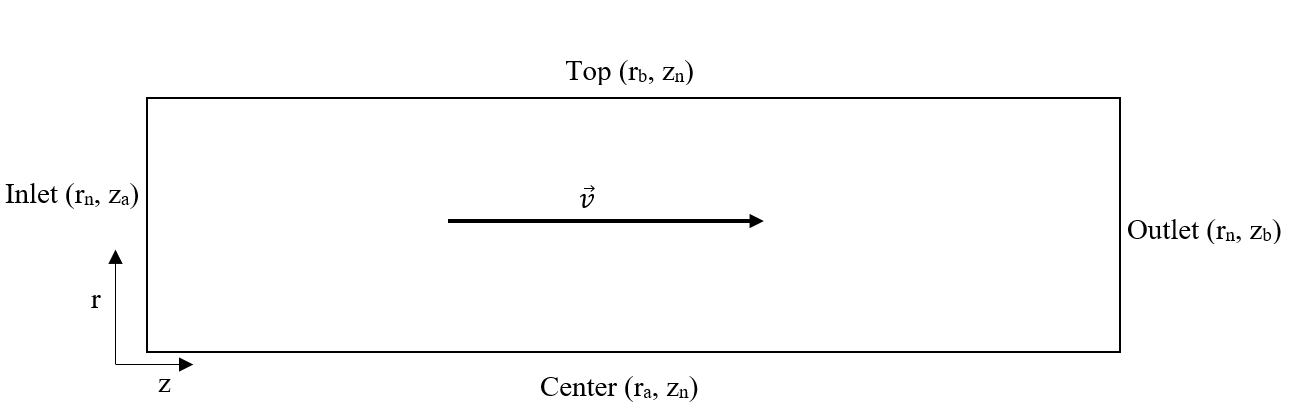

With the following Boundary Conditions \
[**Top**] : $ -q(r_b,z_n) = k(u(r)-u_\infty ) $ \
[**Center**] : $ q(r_a,z_n) = 0 $ \
[**Inlet**] : $ u(r_n,z_a) = a $ \
[**Outlet**] : $ q(r_n,z_b) = 0 $ 






### [Weak Form of Problem Statement](#toc)<a id="weakform"></a> 

<br>
 Poissons Convection-Diffusion Model:
\begin{align*}
-\frac{1} {r}\frac{d} {dr}(Dr\frac{du} {dr})+\vec{v} \frac{du}{dz} =-D\nabla^2 u +\vec{v}\nabla u = 0.   \ \ (1)
\end{align*}

Multiplying by wieghted test function $\varphi\ =u(r,z)$. Followed by integration over domain $\Omega$ 
\begin{align*}
\int_\Omega (\, -\varphi D\nabla^2 u+\varphi \vec{v}\cdot\nabla u)d\Omega = 0. \ \ (2)
\end{align*}

Integration of Diffusion Term requires by parts and utilization of divergance theorem:
\begin{align*}
\int_\Omega -\varphi D\nabla^2 ud\Omega &=\int_\Omega D \nabla \varphi \cdot \nabla u\ d\Omega -\int_{\ d\Omega\ }\ \varphi D(\vec{n}\cdot\nabla u)dA         \ \ \ \             (3)
\end{align*}

Substitution of (3) into (2), results in the weak form: 
\begin{align*}
\int_\Omega D \nabla \varphi \cdot \nabla u\ d\Omega+\int_\Omega\vec{v} \cdot\nabla u\ d\Omega\ -\int_{\ d\Omega\ } \varphi D(\vec{n}\cdot\nabla u)dA =0\ \ \ (4)
\end{align*}

Where the last term in (3) is the boundary condition normal to the domain (i.e outflow and inflow)

\begin{align*} 
\ D ( \vec{n} \cdot \nabla u \ ) \ = D ( \ n_r \frac{du}{dr}+n_z\frac{du}{dz} \ ) \ \ \ \ \ (5)
\end{align*}

Substitution of (5) and the following approximate solution into the wear form (4): 
\begin{align*}
u(r,z)= \sum_{j=1}^{NN}c_j\phi_j(r,z)\ \  \ \ \ \ (6)
\end{align*}

Along with selecting the weighted function to be the $i^{th}$ shape function, i.e $\varphi =\phi_i(r,z)$, results in a computational $i{th}$ linear algebraic residual equationg for NN many nodal unknowns that MOOSE will solve computationally:

\begin{align*}
R_i(r,z)= \sum_{j=1}^{NN}c_j\int_\Omega 
[\phi_i ( V_r\frac{ \partial \phi_j }{\partial r} \ + V_z\frac{ \partial \phi_j }{\partial z} )\ + D\ (\frac{ \partial \phi_i }{\partial z} \frac{ \partial \phi_j }{\partial z} + \frac{ \partial \phi_i }{\partial r} \frac{ \partial \phi_j }{ \partial r}\ ) \ d \Omega \ ]
\ - \int_{\ d \Omega} \phi_i\ [\ D ( \ n_r \frac{du}{dr} \ + \ n_z \frac{du}{dz} \ ) \ ] \ dA  \ \ \ \ \ (7)
\end{align*}


### [MOOSE Kernels](#toc)<a id="kernels"></a>

In order to input the weak form of the receding problem statment into MOOSE, it must be written in inner product notation:

\begin{align*} 
( \nabla \varphi  , D \nabla u ) - < \varphi ,D \nabla u \cdot \vec{n} > + ( \varphi , \vec {v} \cdot \nabla u )=0. 
 \end{align*}

 Where, in MOOSE\
$ ( \nabla \varphi \ , \ D \nabla u\ )  = $ Kernel
 
$ < \varphi , D\nabla u\cdot \vec{n} > = $ Boundary Condition 

$ ( \varphi , \vec {v} \cdot \nabla u ) = $ Kernel 
 

Therefore the MOOSE kernels used in this project to solve the [weak form](#weakform) are as followed:


**Diffusion Kernel** : $(\nabla \varphi,D\nabla u)$

 + [DiffusionTerm.h](./include/kernels/X.h) and [DiffusionTerm.C](./src/kernels/X.C)
 
 
**Convection Kernel** : $ ( \varphi,\vec {v} \cdot \nabla u)$

 + [ConvectionTerm.h](./include/kernels/X.h) and [ConvectionTerm.C](./src/kernels/X.C).
 
**Boundary Conditions** : $ <\varphi,D\nabla u\cdot\vec{n}> $ 

[**Top**] - [NormalFluxBC.h](./include/kernels/X.h) and [NormalFluxBC.C](./src/kernels/X.C)
 
$-q(z_n, r_b) = k(u(r)-u_\infty ) $

[**Center**]-  MOOSE implemented NeumannBC 

$ q(z_n, r_a) = 0 $
 
[**Inlet**] - MOOSE implemented DirichletBC

$ u(z_a, r_n) = a $

[**Outlet**] - MOOSE implemented NeumannBC 

$ q(z_b, r_n) = 0 $



### [Partitioning of Mesh](#toc)<a id="Mesh"></a>
Recall that Largrange polynomials are not very flexible to approximate functions over a domain. Where to over come this infelxiblity, partitioning of the domain into "smaller" slices will often reach better convergance. For this particlar domain a Nine quadrilateral elements was used as the mesh of the pipe, which is most common amongst 2D FEM problems. A Nine quadrilateral elmenet for a single element in both dimensions (r,z) follows: 

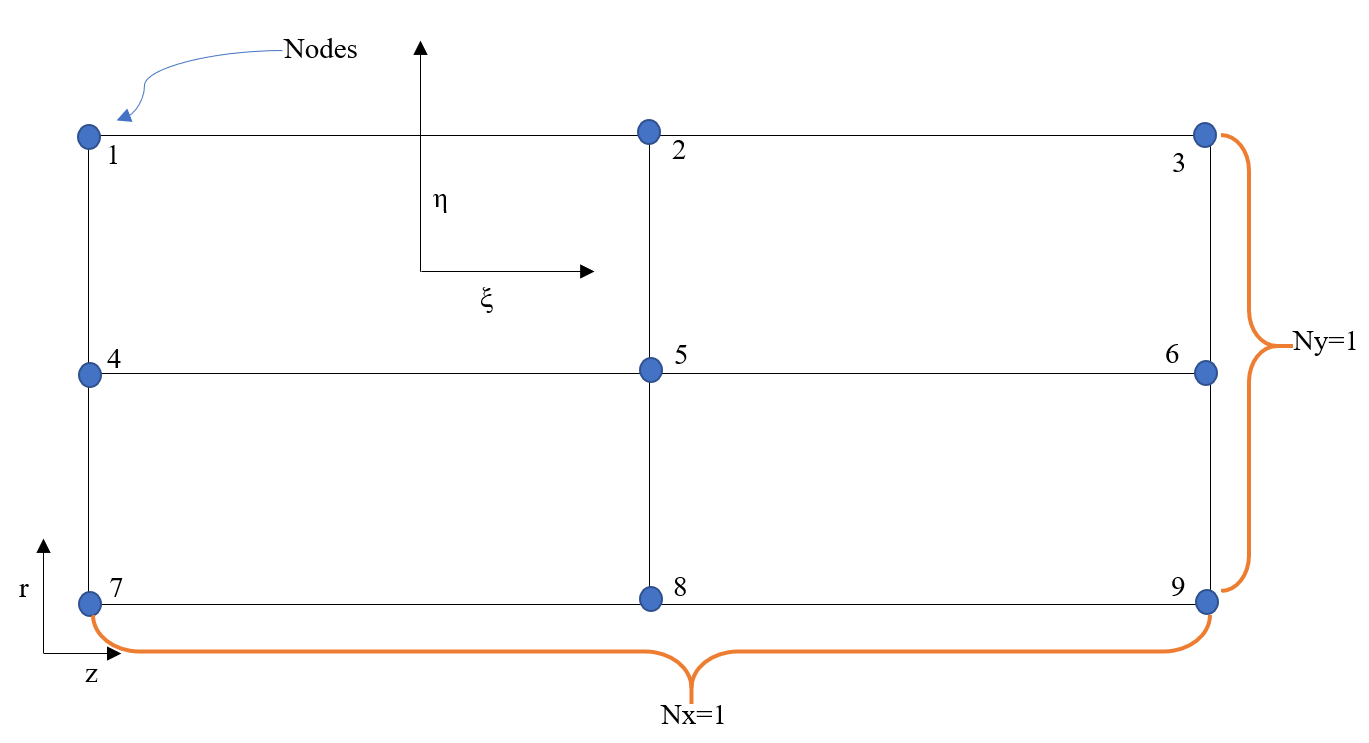

 
Where, the shape function $ \phi (\xi ,\eta )$ varies between $ N_{ij}  $ and follows the General form: 

$ \phi = A + B\xi + C\eta + D\eta\xi $

Partitioning of domain into smaller rectangles, as opposed to bilateral mesh, increases the approximated accuracy of the polynomials. 


### [Error Analysis](#toc)<a id="Error Analysis"></a>
<br>
In 2D $(r,z)$ coordinates can be written in terms of $(\xi,\eta)$ coordinates by using the previously defined 2D shape functions as follows: 

\begin{align*}
r(\xi ,\eta ) =\sum_{j=1}^{NEN}r^e_j \phi_j(\xi,\eta) \ \ \ (8)  \ \ \ \ \ z(\xi ,\eta ) =\sum_{j=1}^{NEN}z^e_j \phi_j(\xi,\eta) \  \ \ \ (9)
\end{align*} 

Where $NEN$ is the node number of an element equal to 36 for nine quadrilateral elements (9x4), and $r^e_j$ and $z^e_j$ are the known nodal coordinates of the element. For optimization of residual the dependency of $ \varphi $ , the test functions, on $(r,z)$ coordinates is determined by computing the Jacobian. Substituting (8) and (9) and differentiating results in the following Jacobian:

\begin{align*}
 J(\xi,\eta)= \ 
 \begin{bmatrix} 
\frac{\partial \phi_j}{\partial \xi }  \\ 
\frac{\partial \phi_j}{\partial \eta}  \\ 
\end{bmatrix}
=
\begin{bmatrix} 
\frac{\partial r }{\partial \xi} & \frac{\partial z }{\partial \xi}  \\ 
\frac{\partial r }{\partial \eta} & \frac{\partial r }{\partial \eta} \\ 
\end{bmatrix}
\cdot
\begin{bmatrix} 
\frac{\partial \phi_i }{\partial \xi}   \\ 
\frac{\partial \phi_i }{\partial \eta}  \\ 
\end{bmatrix}
 \end{align*}

In MOOSE this Jacobian is determined by a preconditions Jacobian matrix **PJFNK** 


### [Setup](#toc)<a id="setup"></a>

In [ ]:
'''Domain'''

z_left = 0 #cm
z_right =150 #cm
r_bottom=0 #cm
r_top=7.5 #cm



In [10]:
'''Parameters'''

diff_coeff = .000266493 #cm2/s
s_source = 0



In [41]:
'''Data (boundary conditions)'''

u_inlet = 3.6e-07 #ug/cc
q_center=0 #ug/cm^2
q_bottom=0 #ug/cm^2
ambient_conc = 0 #ug/cm^2
vel=[5.45, 0 ,0] #cm/s
Mass_transfer_coef= 2.35e-03 #cm/s

In [51]:
'''FEM Solution'''

n_felem_x = 1
n_felem_y = 1
mesh_type='QUAD9'
order = 'second'



from tools.toolkit  import write_engy5310_p1_2d_input_file


write_engy5310_p1_2d_input_file(xmin=z_right, 
                                xmax=z_left, 
                                yminx=r_bottom, 
                                ymax=r_top, 
                                u_inlet=u_inlet, 
                                flux_center=q_center,
                                flux_bottom=q_bottom,
                                Ambient_conc=ambient_conc,
                                velocity=vel,
                                Mass_transfer_coef=Mass_transfer_coef,
                                diff_coeff=diff_coeff, 
                                source_s=source_s, 
                                n_felem_x=n_felem_x, 
                                n_felem_y=n_felem_y, 
                                degree=order,
                                mesh_type=mesh_type,
                                compute_diffusion_flux=True,
                                use_moose_neumann_bc=True,
                                file_name='input.hit')


ModuleNotFoundError: No module named 'tools'

In [43]:
!./engy5310p1-opt -i input.hit

'.' is not recognized as an internal or external command,
operable program or batch file.


## [Results and Analysis](#toc)<a id="ranalysis"></a>

In [44]:

'''Plot function for FEM Solution'''

def plot_solution(df,
                  dimension='Null',
                  title='No Title', 
                  basis_functions_type='No basis functions type',
                  flux_basis_functions_type='No basis functions type'):
    
    import matplotlib.pyplot as plt
    %matplotlib inline
    import numpy as np
    plt.style.use('dark_background')
    radial ="r" 
    axial="z"
    (fig, ax1) = plt.subplots(1, figsize=(14, 5))
    
    #radial plot
    
    if (radial == dimension):
        ax1.plot(df['y'], df['u'],'r*-',label=basis_functions_type)

        ax1.set_xlabel(r'$r$ ', fontsize=18)
        ax1.set_ylabel(r'$u_h(r)$ [µg/cc]', fontsize=18, color='red')
        ax1.tick_params(axis='y', labelcolor='red', labelsize=14)
        ax1.tick_params(axis='x', labelsize=14)
        ax1.legend(loc='center left', fontsize=12)
        ax1.grid(True)
        
        ## Flux Plot 
        
        ax2 = ax1.twinx()
        ax2.plot(df['y'], df['diffFluxU_radius'],'b*-',label=flux_basis_functions_type)

        ax2.set_ylabel(r"$q_h(r)$ [µg/cm2-s]", fontsize=16, color='lightblue')
        ax2.tick_params(axis='y', labelcolor='lightblue', labelsize=14)
        ax2.legend(loc='center right', fontsize=12)
        
    #Axial plot   
    
    if (axial == dimension):
        ax1.plot(df['x'], df['u'],'r*-',label=basis_functions_type)

        ax1.set_xlabel(r'$z$ [cm]', fontsize=18)
        ax1.set_ylabel(r'$u_h(z)$ [µg/cc]', fontsize=18, color='red')

        ax1.tick_params(axis='y', labelcolor='red', labelsize=14)
        ax1.tick_params(axis='x', labelsize=14)
        ax1.legend(loc='center left', fontsize=12)
        ax1.grid(True)
        
        ## Flux Plot 
            
        ax2 = ax1.twinx()

        ax2.plot(df['x'], df['diffFluxU_axial'],'b*-',label=flux_basis_functions_type)
        
        ax2.set_ylabel(r"$q_h(x)$ [µg/cm2-s]", fontsize=16, color='lightblue')
        ax2.tick_params(axis='y', labelcolor='lightblue', labelsize=14)
        ax2.legend(loc='center right', fontsize=12)
      



    plt.title(title, fontsize=20)
  
    plt.show()
    print('')

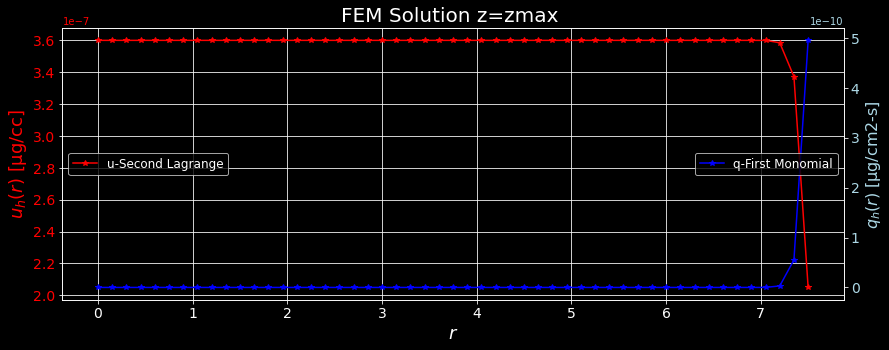

In [45]:
import pandas as pd
df = pd.read_csv('out-radial_radial-line_0002.csv')

    
plot_solution(df, dimension='r', title='FEM Solution z=zmax ', basis_functions_type='u-Second Lagrange', flux_basis_functions_type='q-First Monomial')

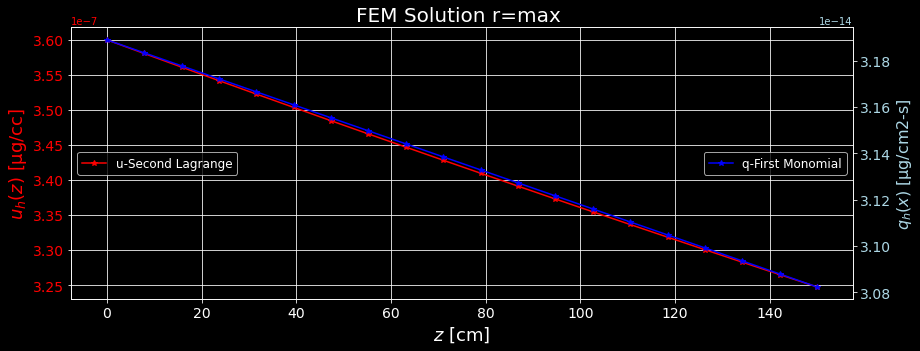

In [39]:
import pandas as pd
df = pd.read_csv('out-axial_axial-line_0002.csv')

    
plot_solution(df, dimension='z', title='FEM Solution r=max ', basis_functions_type='u-Second Lagrange',flux_basis_functions_type='q-First Monomial')

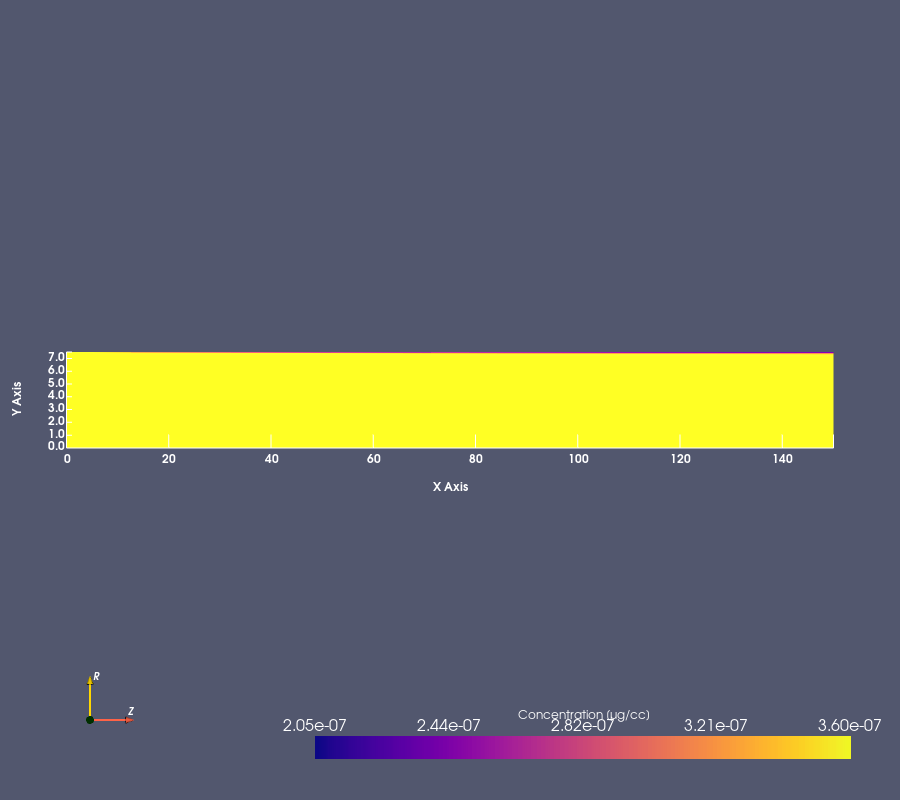

In [48]:

'''Show 2D solution'''

import pyvista as pv
poisson = pv.read('out_000_0.vtu')

plo = pv.Plotter()   

plo.add_mesh(poisson, scalars='u', cmap='plasma', stitle='Concentration [µg/cc]')


plo.add_axes(xlabel='Z', ylabel='R', zlabel='')
plo.show_bounds()
plo.set_scale(xscale=2, yscale=5, zscale=None, reset_camera=True)
plo.set_viewup([0,1,0])


cpos = plo.show(window_size=[900, 800])


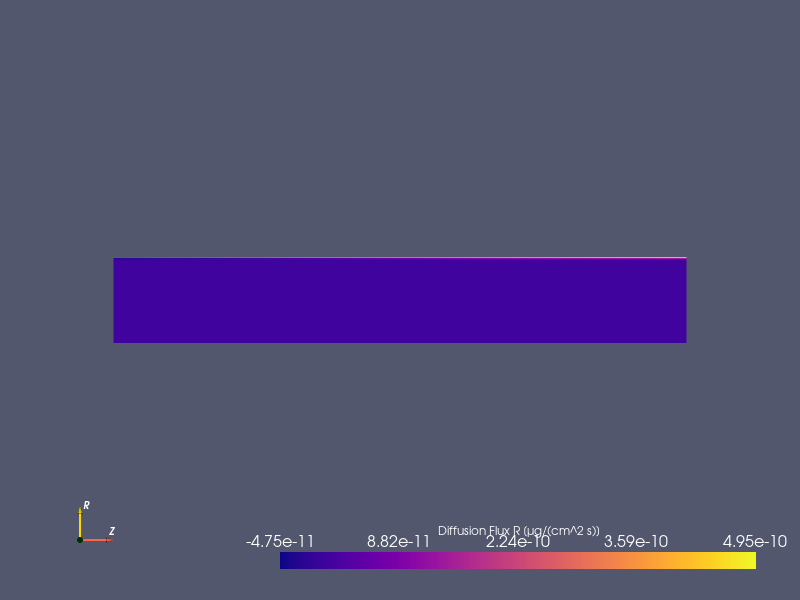

In [49]:
'''Show 2D solution'''

import pyvista as pv

poisson = pv.read('out_000_0.vtu')

plo = pv.Plotter()   
plo.add_mesh(poisson, scalars='diffFluxU_radius', cmap='plasma', stitle='Diffusion Flux R [µg/(cm^2 s)]')
plo.add_axes(xlabel='Z', ylabel='R', zlabel='')



plo.set_scale(xscale=None, yscale=3, zscale=None, reset_camera=True)
plo.set_viewup([0,1,0])

cpos = plo.show(window_size=[800, 600])


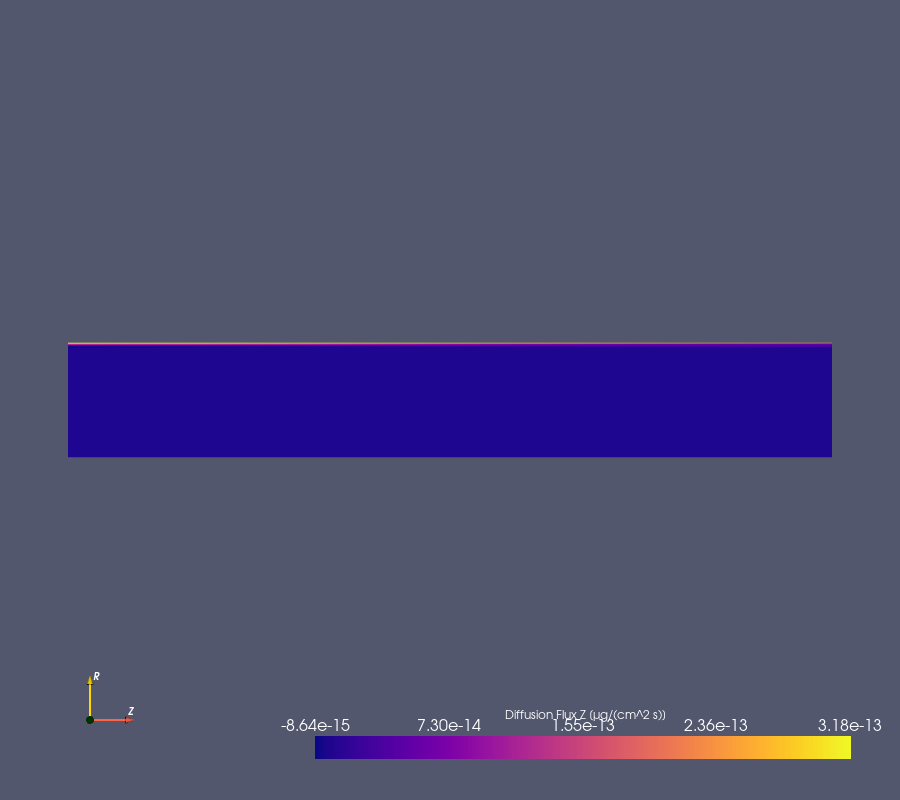

In [50]:
'''Show 2D solution'''

import pyvista as pv

poisson = pv.read('out_000_0.vtu')
plo = pv.Plotter()   
plo.add_mesh(poisson, scalars='diffFluxU_axial', cmap='plasma', stitle='Diffusion Flux Z [µg/(cm^2 s)]')
plo.add_axes(xlabel='Z', ylabel='R', zlabel='')

plo.set_scale(xscale=None, yscale=3, zscale=None, reset_camera=True)

plo.set_viewup([0,1,0])


cpos = plo.show(window_size=[900, 800])


## [Conclusions](#toc)<a id="conclusions"></a>

- Text...

- Text...

## [References](#toc)<a id="refs"></a>

- [1] V. F. de Almeida, [*Engy-5310: Computational Continuum Transport Phenomena*](https://github.com/dpploy/engy-5310),  University of Massachusetts Lowell, Dept. of Chemical Engineering (Nuclear Energy Program).
- [2] Multiphysics Object-Oriented Simulation Environment [(MOOSE)](https://mooseframework.org)
- [3] Stempien D. John, “Tritium Transport, Corrosion, and Fuel Performance Modeling in Fluoride Salt-Cooled High-Temperature Reactor (FHR)”. Massachusetts Institute of Technology. PDF. June 2017
- [4] R. Serrano-Lópeza, J. Fraderaa, S. Cuesta-Lópeza. “Molten salts database for energy applications”. PDF. September 2014.